In [1]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from skimage import io
from torchvision.datasets import DatasetFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
os.system('wget http://madm.dfki.de/files/sentinel/EuroSAT.zip')
!unzip EuroSAT.zip

Streaming output truncated to the last 5000 lines.
  inflating: 2750/SeaLake/SeaLake_2206.jpg  
  inflating: 2750/SeaLake/SeaLake_1313.jpg  
  inflating: 2750/SeaLake/SeaLake_263.jpg  
  inflating: 2750/SeaLake/SeaLake_967.jpg  
  inflating: 2750/SeaLake/SeaLake_515.jpg  
  inflating: 2750/SeaLake/SeaLake_1465.jpg  
  inflating: 2750/SeaLake/SeaLake_1817.jpg  
  inflating: 2750/SeaLake/SeaLake_2902.jpg  
  inflating: 2750/SeaLake/SeaLake_2570.jpg  
  inflating: 2750/SeaLake/SeaLake_1004.jpg  
  inflating: 2750/SeaLake/SeaLake_174.jpg  
  inflating: 2750/SeaLake/SeaLake_2111.jpg  
  inflating: 2750/SeaLake/SeaLake_2388.jpg  
  inflating: 2750/SeaLake/SeaLake_1948.jpg  
  inflating: 2750/SeaLake/SeaLake_838.jpg  
  inflating: 2750/SeaLake/SeaLake_2738.jpg  
  inflating: 2750/SeaLake/SeaLake_1999.jpg  
  inflating: 2750/SeaLake/SeaLake_2359.jpg  
  inflating: 2750/SeaLake/SeaLake_2660.jpg  
  inflating: 2750/SeaLake/SeaLake_1775.jpg  
  inflating: 2750/SeaLake/SeaLake_605.jpg  
  inflatin

In [67]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
random.seed(0)

In [68]:
# Define the data directory
data_dir = "/content/2750"

# Define the transforms to be applied to the images
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize(...)
])

In [69]:
dataset = ImageFolder(root=data_dir, transform=transform)

train_set, val_set = train_test_split(dataset, test_size=0.2)#, stratify=dataset.targets)
  
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=3, drop_last = True)
val_loader   = DataLoader(val_set,   batch_size=16, shuffle=True, num_workers=0, drop_last = True)

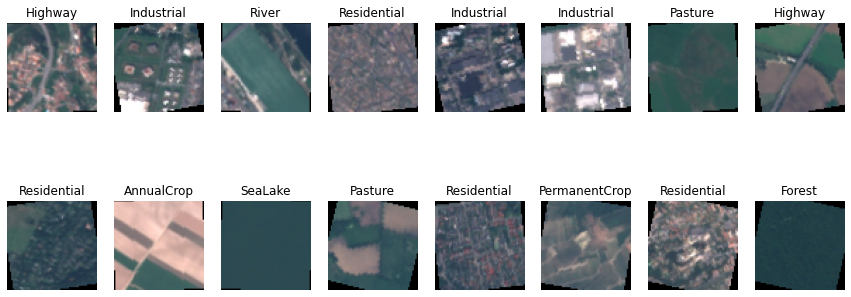

In [70]:
# Get a batch of images from the train_loader
images, labels = next(iter(train_loader))

# Plot the images with their corresponding labels
fig, axs = plt.subplots(2, 8, figsize=(15, 6))
for i in range(16):
    row = i // 8
    col = i % 8
    image = images[i].permute(1, 2, 0).numpy()
    label = dataset.classes[labels[i]]
    axs[row][col].imshow(image)
    axs[row][col].set_title(label)
    axs[row][col].axis('off')
plt.show()

In [71]:
# Train fast!
torch.cuda.is_available()

True

In [72]:
class Metrics:
    def __init__(self, metric_funcs):
        self.metric_funcs = metric_funcs

    def __call__(self, y_pred, y_true):
        metric_values = {}
        for metric_func in self.metric_funcs:
            metric_name = metric_func.__name__
            metric_value = metric_func(y_pred, y_true)
            metric_values[metric_name] = metric_value
        return metric_values

    def names(self):
        return [metric_func.__name__ for metric_func in self.metric_funcs]

In [73]:
# Define metric functions (What are you interested in?)
def accuracy(y_pred, y_true):
    acc = (y_pred == y_true).float().mean()
    return acc.item()

def precision(y_pred, y_true):
    TP = ((y_pred == 1) & (y_true == 1)).sum().item()
    FP = ((y_pred == 1) & (y_true == 0)).sum().item()
    return TP / (TP + FP) if (TP + FP) != 0 else 0

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from tqdm import tqdm

# Load the pre-trained ResNet18 model (Choose the model)
model = models.resnet18(pretrained=True)

# Replace the last fully connected layer with a new one
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define the number of epochs
num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define metrics to save
save_metrics = Metrics([accuracy, precision])
train_metrics = {'loss' : [], **{name : [] for name in save_metrics.names()}}
val_metrics =   {'loss' : [], **{name : [] for name in save_metrics.names()}}

for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_step = 0

    for images, labels in tqdm(train_loader, desc='I\'m studying hard now🧐, don\'t disturb!'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_step += 1
        pred_labels = torch.argmax(outputs, dim=1)

        train_metrics['loss'].append(loss.item())
        for name, value in save_metrics(pred_labels, labels).items():
            train_metrics[name].append(value)

    # Evaluate the model on the validation set
    model.eval()
    val_step = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_step += 1
            pred_labels = torch.argmax(outputs, dim=1)
            val_metrics['loss'].append(loss.item())
            for name, value in save_metrics(pred_labels, labels).items():
                val_metrics[name].append(value)
    
    # Print the metrics for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    for name in train_metrics:
        train_metric = sum(train_metrics[name][-train_step:]) / train_step
        val_metric = sum(val_metrics[name][-val_step:]) / val_step
        print(f"  {name}: train={train_metric:.4f}, val={val_metric:.4f}")

#TODO: Add Grapgh

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
I'm studying hard now🧐, don't disturb!:   0%|          | 0/1350 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive w

Epoch [1/10]
  loss: train=0.5548, val=0.2273
  accuracy: train=0.8178, val=0.9253
  precision: train=0.8238, val=0.8131


I'm studying hard now🧐, don't disturb!: 100%|██████████| 1350/1350 [00:31<00:00, 43.54it/s]


Epoch [2/10]
  loss: train=0.2729, val=0.1868
  accuracy: train=0.9092, val=0.9373
  precision: train=0.8396, val=0.8220


I'm studying hard now🧐, don't disturb!: 100%|██████████| 1350/1350 [00:29<00:00, 46.46it/s]


Epoch [3/10]
  loss: train=0.1889, val=0.1958
  accuracy: train=0.9355, val=0.9347
  precision: train=0.8341, val=0.8442


I'm studying hard now🧐, don't disturb!: 100%|██████████| 1350/1350 [00:28<00:00, 47.04it/s]


Epoch [4/10]
  loss: train=0.1476, val=0.1881
  accuracy: train=0.9495, val=0.9371
  precision: train=0.8235, val=0.8338


I'm studying hard now🧐, don't disturb!: 100%|██████████| 1350/1350 [00:29<00:00, 46.26it/s]


Epoch [5/10]
  loss: train=0.1163, val=0.1648
  accuracy: train=0.9596, val=0.9447
  precision: train=0.8448, val=0.8388


I'm studying hard now🧐, don't disturb!: 100%|██████████| 1350/1350 [00:28<00:00, 47.11it/s]


Epoch [6/10]
  loss: train=0.0888, val=0.1903
  accuracy: train=0.9695, val=0.9414
  precision: train=0.8514, val=0.8620


I'm studying hard now🧐, don't disturb!: 100%|██████████| 1350/1350 [00:29<00:00, 46.53it/s]


Epoch [7/10]
  loss: train=0.0637, val=0.1718
  accuracy: train=0.9779, val=0.9457
  precision: train=0.8505, val=0.8309


I'm studying hard now🧐, don't disturb!: 100%|██████████| 1350/1350 [00:28<00:00, 47.16it/s]


Epoch [8/10]
  loss: train=0.0661, val=0.1584
  accuracy: train=0.9781, val=0.9531
  precision: train=0.8506, val=0.8457


I'm studying hard now🧐, don't disturb!: 100%|██████████| 1350/1350 [00:32<00:00, 42.11it/s]


Epoch [9/10]
  loss: train=0.0459, val=0.1463
  accuracy: train=0.9851, val=0.9555
  precision: train=0.8378, val=0.8175


I'm studying hard now🧐, don't disturb!: 100%|██████████| 1350/1350 [00:29<00:00, 46.16it/s]


Epoch [10/10]
  loss: train=0.0444, val=0.2014
  accuracy: train=0.9858, val=0.9468
  precision: train=0.8646, val=0.8353


In [80]:
# Save the trained model
torch.save(model.state_dict(), 'resnet18.pth')

import json

# Save the evaluation metrics to a file
with open('metrics.json', 'w') as f:
    json.dump(val_metrics, f)

In [97]:
len(dataset.samples)

27000

In [102]:
import torch
from torchvision import transforms, datasets

# Define the device to run the inference on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the saved model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(dataset.classes))
model.load_state_dict(torch.load('resnet18.pth'))
model.to(device)

#model = torch.load('resnet18.pth').to(device)

# Define the transformation to apply to the images before feeding them to the model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset and apply the transformation to the images
#dataset = datasets.ImageFolder('path/to/dataset', transform=transform)

# Select 20 sample images from the dataset
sample_indices = [i for i in range(0, 20000, 1000)]
sample_images = [dataset[i][0] for i in sample_indices]

# Perform inference on the sample images
if not os.path.exists('results'):
    os.makedirs('results')
model.eval()
with torch.no_grad():
    for i, image in enumerate(sample_images):
        # Add a batch dimension to the image tensor
        image = image.unsqueeze(0).to(device)

        # Pass the image through the model to get the predicted class probabilities
        probs = torch.softmax(model(image), dim=1)[0]
        predicted_class = torch.argmax(probs).item()
        
        # Save the predicted class and its probability to a text file
        img_path, _ = dataset.samples[sample_indices[i]]
        img_format_len = 4 #.jpg
        img_name = os.path.basename(img_path)[:-img_format_len]
        with open(f'results/{img_name}.txt', 'w') as f:
            f.write(f'Predicted class: {dataset.classes[predicted_class]}\n')
            f.write('Class probabilities:\n')
            for j, prob in enumerate(probs):
                f.write(f'{dataset.classes[j]}: {prob.item()}\n')
